**Context**

To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the [VIGIA project](https://jivg.org/research-projects/vigia/), which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

**Data description provided**

This dataset contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo). Kaggle has resized the images from the original dataset to make them uniform in size. The file name of an image corresponds to its id.

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

In [2]:
import os
print(os.listdir("../input"))

['test', 'train', 'train.csv', 'sample_submission.csv']


In [7]:
train_dir="../input/train/train"
test_dir="../input/test/test"
train = pd.read_csv('../input/train.csv')
sub_file = pd.read_csv("../input/sample_submission.csv")
data_folder = Path("../input")

In [8]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [9]:
sub_file.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [11]:
# transformations for data augmentation
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [21]:
test_img = ImageList.from_df(sub_file, path=data_folder/'test', folder='test')

databunch = (ImageList.from_df(train, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=48)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

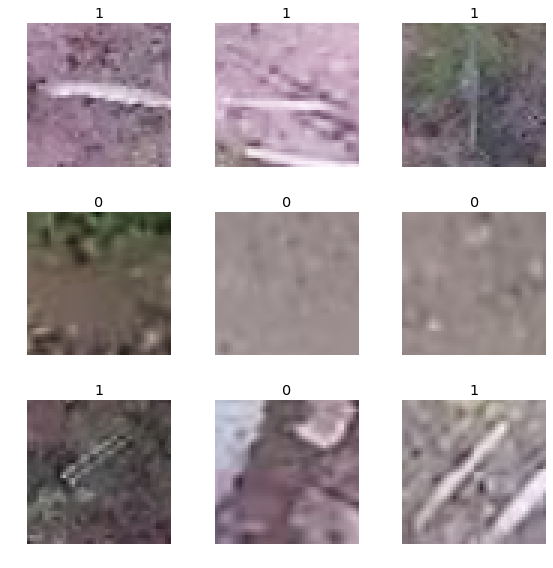

In [22]:
databunch.show_batch(rows=3, figsize=(8,8))

**has_cactus = 1**

In [23]:
databunch.classes

[0, 1]

In [24]:
databunch.label_list

LabelLists;

Train: LabelList (17325 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,1,1,1,1
Path: ../input/train;

Valid: LabelList (175 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,1,1,1,0
Path: ../input/train;

Test: LabelList (4000 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: EmptyLabelList
,,,,
Path: ../input/train

In [25]:
learn = cnn_learner(databunch, models.resnet34, metrics=[error_rate, accuracy])
learn.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 42906861.72it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.120911,0.052952,0.022857,0.977143,00:53
1,0.058878,0.018675,0.005714,0.994286,00:51
2,0.033865,0.018959,0.005714,0.994286,00:52
3,0.029315,0.023925,0.011429,0.988571,00:50
4,0.032069,0.017850,0.011429,0.988571,00:51


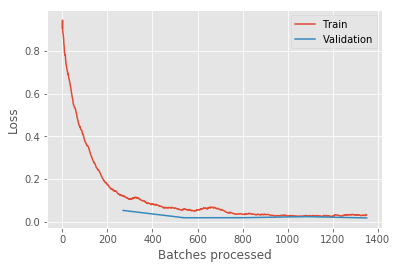

In [26]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


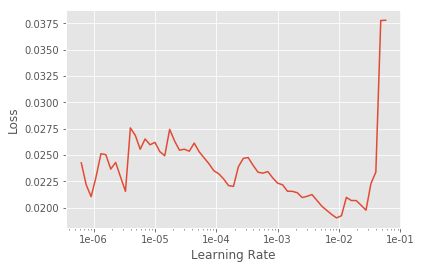

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.026603,0.007590,0.005714,0.994286,00:53
1,0.017404,0.001373,0.000000,1.000000,00:51
2,0.018861,0.009910,0.005714,0.994286,00:50
3,0.004561,0.002164,0.000000,1.000000,00:51
4,0.001923,0.000298,0.000000,1.000000,00:51


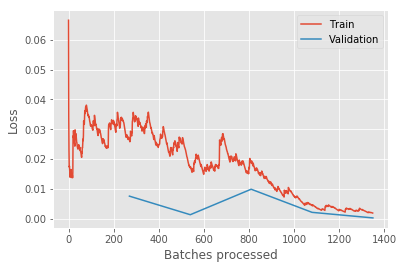

In [34]:
learn.recorder.plot_losses()

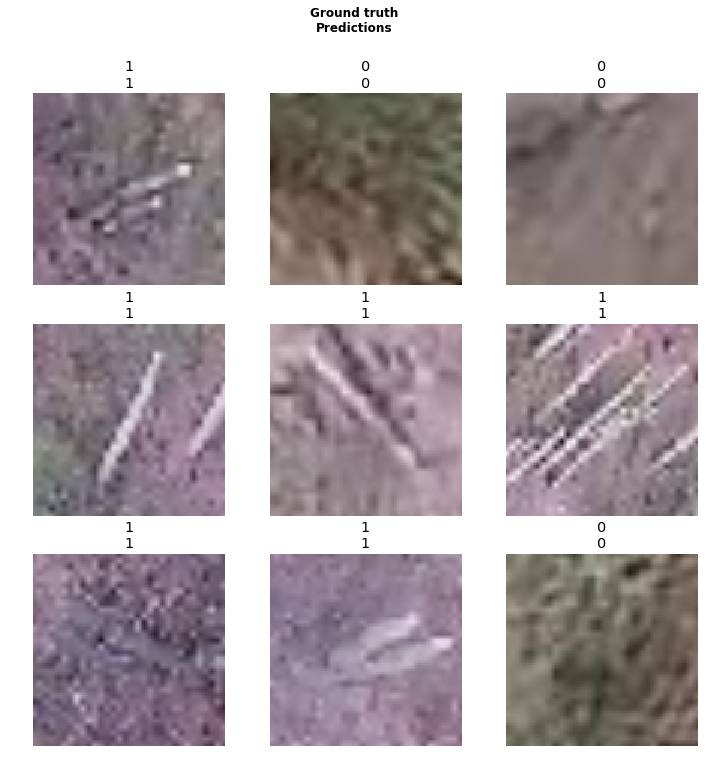

In [29]:
learn.show_results(rows=3)

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(databunch.valid_ds)==len(losses)==len(idxs)

True

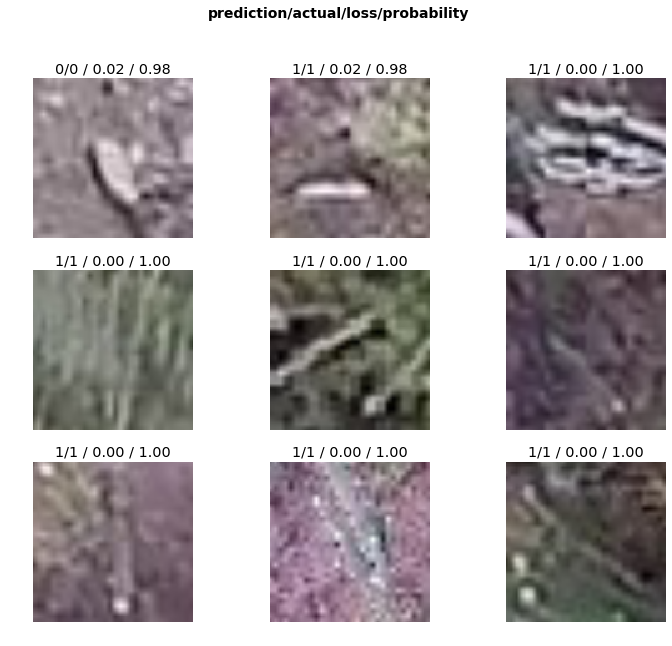

In [32]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

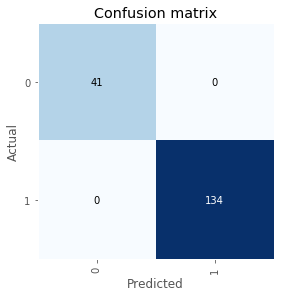

In [33]:
interp.plot_confusion_matrix()

In [35]:
predictions1=learn.get_preds(DatasetType.Test)
predictions2=learn.get_preds(DatasetType.Test)
predictions3=learn.get_preds(DatasetType.Test)
predictions4=learn.get_preds(DatasetType.Test)
predictions5=learn.get_preds(DatasetType.Test)
predictions6=learn.get_preds(DatasetType.Test)
predictions7=learn.get_preds(DatasetType.Test)
predictions8=learn.get_preds(DatasetType.Test)

comb_output=[predictions1[0],predictions2[0],predictions3[0],predictions4[0],
            predictions5[0],predictions6[0],predictions7[0],predictions8[0]]

comb_output=torch.sum(torch.stack(comb_output),dim=0)

In [36]:
sub_file.has_cactus = comb_output.numpy()[:, 0]
sub_file.to_csv('submission.csv', index=False)